## Combined Aleatoric and Epistemic UQ for PtychoNN
Using Kendall and Gal's approach: https://proceedings.neurips.cc/paper/2017/hash/2650d6089a6d640c5e85b2b88265dc2b-Abstract.html

Implemented in 1D here: https://github.com/mcherukara/UQ_NNs

Apply dropout before ReLu: https://sebastianraschka.com/faq/docs/dropout-activation.html

### - Update params.py file as required!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm 
import numpy as np
from skimage.transform import resize

import matplotlib.pyplot as plt
import matplotlib

import os

from sklearn.utils import shuffle

import params
params.set_gpu_env()

torch.__version__

/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPUs: 2 Batch size: 64 Learning rate: 0.002


'1.11.0'

In [2]:
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20
plt.viridis()

<Figure size 432x288 with 0 Axes>

In [3]:
def plot3(data,titles):
    if(len(titles)<3):
        titles=["Plot1", "Plot2", "Plot3"]
    fig,ax = plt.subplots(1,3, figsize=(20,12))
    im=ax[0].imshow(data[0])
    ax[0].set_title(titles[0])
    ax[0].axis('off')
    plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
    im=ax[1].imshow(data[1])
    ax[1].set_title(titles[1])
    ax[1].axis('off')
    plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
    im=ax[2].imshow(data[2])
    ax[2].set_title(titles[2])
    ax[2].axis('off')
    plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)

**Note that the "path" can be different for different directory structures. For example, the original code in train.ipynb contains a different path.**  

In [4]:
path = os.getcwd()

MODEL_SAVE_PATH = path +'/trained_model/'
if (not os.path.isdir(MODEL_SAVE_PATH)):
    os.mkdir(MODEL_SAVE_PATH)

In [5]:
data_diffr = np.load('../../../data/20191008_39_diff.npz')['arr_0']#np.load(path+'/../data/20191008_39_diff.npz')['arr_0']
real_space = np.load('../../../data/20191008_39_amp_pha_10nm_full.npy')#np.load(path+'/../data/20191008_39_amp_pha_10nm_full.npy')

amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

In [6]:
try:
    data_diffr_red = np.load('../../../data/20191008_39_diff_reduced.npz')['arr_0']
except:
    print(data_diffr.shape)

    data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), dtype=float)
    for i in tqdm(range(data_diffr.shape[0])):
        for j in range(data_diffr.shape[1]):
            data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
            data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])
    np.savez_compressed('../../data/20191008_39_diff_reduced.npz', data_diffr_red)
data_diffr.shape, data_diffr_red.shape

((161, 161, 256, 256), (161, 161, 64, 64))

In [7]:
tst_strt = amp.shape[0]-params.NLTEST #Where to index from
print(tst_strt)

X_train = data_diffr_red[:params.NLINES,:].reshape(-1,params.H, params.W)[:,np.newaxis,:,:]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,params.H, params.W)[:,np.newaxis,:,:]
Y_I_train = amp[:params.NLINES,:].reshape(-1,params.H, params.W)[:,np.newaxis,:,:]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,params.H, params.W)[:,np.newaxis,:,:]
Y_phi_train = ph[:params.NLINES,:].reshape(-1,params.H, params.W)[:,np.newaxis,:,:]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,params.H, params.W)[:,np.newaxis,:,:]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

101
(16100, 1, 64, 64) (3600, 1, 64, 64)


In [8]:
#Training data
X_train_tensor = torch.Tensor(X_train) 
Y_I_train_tensor = torch.Tensor(Y_I_train) 
Y_phi_train_tensor = torch.Tensor(Y_phi_train)

#Test data
X_test_tensor = torch.Tensor(X_test) 
Y_I_test_tensor = torch.Tensor(Y_I_test) 
Y_phi_test_tensor = torch.Tensor(Y_phi_test)

print(Y_phi_train.max(), Y_phi_train.min())

print(X_train_tensor.shape, Y_I_train_tensor.shape, Y_phi_train_tensor.shape)

train_data = TensorDataset(X_train_tensor,Y_I_train_tensor,Y_phi_train_tensor)
test_data = TensorDataset(X_test_tensor)

3.1268637 -1.564053
torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64]) torch.Size([16100, 1, 64, 64])


In [9]:
N_TRAIN = X_train_tensor.shape[0]
train_data2, valid_data = torch.utils.data.random_split(train_data,[N_TRAIN-params.N_VALID,params.N_VALID])
print(len(train_data2),len(valid_data),len(test_data))

15295 805 3600


In [10]:
#download and load training data
trainloader = DataLoader(train_data2, batch_size=params.BATCH_SIZE, shuffle=True, num_workers=4)

validloader = DataLoader(valid_data, batch_size=params.BATCH_SIZE, shuffle=True, num_workers=4)

#same for test
#download and load training data
testloader = DataLoader(test_data, batch_size=params.BATCH_SIZE, shuffle=False, num_workers=4)

In [11]:
nconv = params.nconv
drop = params.drop


class recon_model(nn.Module):

    def __init__(self):
        super(recon_model, self).__init__()


        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
          nn.Conv2d(in_channels=1, out_channels=nconv, kernel_size=3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv, nconv, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),          
          nn.ReLU(),
          nn.MaxPool2d((2,2)),

          nn.Conv2d(nconv*2, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),     
          nn.Dropout(drop),     
          nn.ReLU(),
          nn.MaxPool2d((2,2)),
          )

        self.decoder1 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 2, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Sigmoid() #Amplitude model
          )

        self.decoder2 = nn.Sequential(

          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*4, nconv*4, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*4, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),
            
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Conv2d(nconv*2, nconv*2, 3, stride=1, padding=(1,1)),
          nn.Dropout(drop),
          nn.ReLU(),
          nn.Upsample(scale_factor=2, mode='bilinear'),

          nn.Conv2d(nconv*2, 2, 3, stride=1, padding=(1,1)), #Output conv layer has 2 for mu and sigma
          nn.Tanh() #Phase model
          )
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x1 = self.encoder(x)
            amp = self.decoder1(x1)
            ph = self.decoder2(x1)

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi

        return amp, ph#Return mu and sigma of amp and phase predicts

In [12]:
model = recon_model()
for ft_images,amps,phs in trainloader:
    print("batch size:", ft_images.shape)
    amp_train, ph_train = model(ft_images)
    print(amp_train.shape, ph_train.shape)
    print(amp_train.dtype, ph_train.dtype)
    break

batch size: torch.Size([64, 1, 64, 64])
torch.Size([64, 2, 64, 64]) torch.Size([64, 2, 64, 64])
torch.float32 torch.float32


In [13]:
summary(model,(1,params.H,params.W),device="cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model) #Default all devices

model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             160
           Dropout-2           [-1, 16, 64, 64]               0
              ReLU-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           2,320
           Dropout-5           [-1, 16, 64, 64]               0
              ReLU-6           [-1, 16, 64, 64]               0
         MaxPool2d-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           4,640
           Dropout-9           [-1, 32, 32, 32]               0
             ReLU-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,248
          Dropout-12           [-1, 32, 32, 32]               0
             ReLU-13           [-1, 32, 32, 32]               0
        MaxPool2d-14           [-1, 32,

In [14]:
#Optimizer details
iterations_per_epoch = np.floor((N_TRAIN-params.N_VALID)/params.BATCH_SIZE)+1 #Final batch will be less than batch size
step_size = 6*iterations_per_epoch #Paper recommends 2-10 number of iterations, step_size is half cycle
print("LR step size is:", step_size, "which is every %d epochs" %(step_size/iterations_per_epoch))

optimizer = torch.optim.Adam(model.parameters(), lr = params.LR)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=params.LR / 10, max_lr=params.LR, step_size_up=step_size,
                                              cycle_momentum=False, mode='triangular2')

LR step size is: 1434.0 which is every 6 epochs


In [15]:
#Function to update saved model if validation loss is minimum
def update_saved_model(model, path):
    if not os.path.isdir(path):
        os.mkdir(path)
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
    if (params.NGPUS>1):    
        torch.save(model.module.state_dict(),path+'best_model.pth') #Have to save the underlying model else will always need 4 GPUs
    else:
        torch.save(model,path+'best_model.pth')

**For the "mixed precision" part we just modify the original code slightly to include the 'scaler' in the following code blocks**

In [16]:
scaler = torch.cuda.amp.GradScaler()

In [17]:
#More robust to predict the log variance (regularizer)
def aleatoric_loss(y_pred, y_true):
    mu_pred = y_pred[:,0].unsqueeze(1)#First axis are the predicted means
    sigma_pred = y_pred[:,1].unsqueeze(1)#Second axis are the predicted log variance
    #y_true shape is batch, 1, H, W
    #print(y_true.shape, mu_pred.shape, sigma_pred.shape)
    se = (y_true-mu_pred)**2 
    inv_std = torch.exp(-sigma_pred) 
    mse = torch.mean(inv_std*se) #1/2*exp(-s)*|y-y_pred|**2
    reg = torch.mean(sigma_pred) #1/2*s term
    return 0.5*(mse + reg)

In [18]:
def train(trainloader,metrics):
    tot_loss = 0.0
    loss_amp = 0.0
    loss_ph = 0.0
    
    for i, (ft_images,amps,phs) in tqdm(enumerate(trainloader)):
        ft_images = ft_images.to(device) #Move everything to device
        amps = amps.to(device)
        phs = phs.to(device)

        pred_amps, pred_phs = model(ft_images) #Forward pass

        #Compute losses
        loss_a = aleatoric_loss(pred_amps,amps) #Monitor amplitude loss
        loss_p = aleatoric_loss(pred_phs,phs) #Monitor phase loss
        loss = loss_a + loss_p #Use equiweighted amps and phase
        
        
        #Zero current grads and do backprop
        optimizer.zero_grad() 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #optimizer.step()

        tot_loss += loss.detach().item()
        loss_amp += loss_a.detach().item()
        loss_ph += loss_p.detach().item()

        #Update the LR according to the schedule -- CyclicLR updates each batch
        scheduler.step() 
        metrics['lrs'].append(scheduler.get_last_lr())
        scaler.update()
        
        
    #Divide cumulative loss by number of batches-- sli inaccurate because last batch is different size
    metrics['losses'].append([tot_loss/i,loss_amp/i,loss_ph/i]) 
    

def validate(validloader,metrics):
    tot_val_loss = 0.0
    val_loss_amp = 0.0
    val_loss_ph = 0.0
    for j, (ft_images,amps,phs) in enumerate(validloader):
        ft_images = ft_images.to(device)
        amps = amps.to(device)
        phs = phs.to(device)
        pred_amps, pred_phs = model(ft_images) #Forward pass
    
    
        val_loss_a = aleatoric_loss(pred_amps,amps) 
        val_loss_p = aleatoric_loss(pred_phs,phs)
        val_loss = val_loss_a + val_loss_p
           
        tot_val_loss += val_loss.detach().item()
        val_loss_amp += val_loss_a.detach().item()
        val_loss_ph += val_loss_p.detach().item()  
    metrics['val_losses'].append([tot_val_loss/j,val_loss_amp/j,val_loss_ph/j])
  
  #Update saved model if val loss is lower
    if(tot_val_loss/j<metrics['best_val_loss']):
        print("Saving improved model after Val Loss improved from %.5f to %.5f" %(metrics['best_val_loss'],tot_val_loss/j))
        metrics['best_val_loss'] = tot_val_loss/j
        update_saved_model(model, MODEL_SAVE_PATH)

In [19]:
metrics = {'losses':[],'val_losses':[], 'lrs':[], 'best_val_loss' : np.inf}

In [20]:

for epoch in range (params.EPOCHS):
    
  #Set model to train mode
  model.train() 
    
  #Training loop
  train(trainloader,metrics)

    
  #Switch model to eval mode no more
  #model.eval()
    
  #Validation loop
  validate(validloader,metrics)
  
  print('Epoch: %d | FT  | Train Loss: %.5f | Val Loss: %.5f' %(epoch, metrics['losses'][-1][0], metrics['val_losses'][-1][0]))
  print('Epoch: %d | Amp | Train Loss: %.4f | Val Loss: %.4f' %(epoch, metrics['losses'][-1][1], metrics['val_losses'][-1][1]))
  print('Epoch: %d | Ph  | Train Loss: %.3f | Val Loss: %.3f' %(epoch, metrics['losses'][-1][2], metrics['val_losses'][-1][2]))
  print('Epoch: %d | Ending LR: %.6f ' %(epoch, metrics['lrs'][-1][0]))

0it [00:00, ?it/s]/home/mcherukara/miniconda3/envs/PyTorch1.11/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
239it [00:08, 27.34it/s]


Saving improved model after Val Loss improved from inf to 0.32665
Epoch: 0 | FT  | Train Loss: 0.38262 | Val Loss: 0.32665
Epoch: 0 | Amp | Train Loss: 0.0134 | Val Loss: 0.0041
Epoch: 0 | Ph  | Train Loss: 0.369 | Val Loss: 0.323
Epoch: 0 | Ending LR: 0.000500 


239it [00:05, 44.43it/s]


Saving improved model after Val Loss improved from 0.32665 to 0.19389
Epoch: 1 | FT  | Train Loss: 0.23672 | Val Loss: 0.19389
Epoch: 1 | Amp | Train Loss: 0.0033 | Val Loss: 0.0011
Epoch: 1 | Ph  | Train Loss: 0.233 | Val Loss: 0.193
Epoch: 1 | Ending LR: 0.000800 


239it [00:05, 45.57it/s]


Saving improved model after Val Loss improved from 0.19389 to 0.10317
Epoch: 2 | FT  | Train Loss: 0.13478 | Val Loss: 0.10317
Epoch: 2 | Amp | Train Loss: 0.0007 | Val Loss: 0.0003
Epoch: 2 | Ph  | Train Loss: 0.134 | Val Loss: 0.103
Epoch: 2 | Ending LR: 0.001100 


239it [00:05, 44.87it/s]


Saving improved model after Val Loss improved from 0.10317 to 0.03587
Epoch: 3 | FT  | Train Loss: 0.06145 | Val Loss: 0.03587
Epoch: 3 | Amp | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch: 3 | Ph  | Train Loss: 0.061 | Val Loss: 0.036
Epoch: 3 | Ending LR: 0.001400 


239it [00:05, 46.30it/s]


Saving improved model after Val Loss improved from 0.03587 to 0.01902
Epoch: 4 | FT  | Train Loss: 0.01290 | Val Loss: 0.01902
Epoch: 4 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 4 | Ph  | Train Loss: 0.013 | Val Loss: 0.019
Epoch: 4 | Ending LR: 0.001700 


239it [00:05, 46.00it/s]


Saving improved model after Val Loss improved from 0.01902 to -0.03611
Epoch: 5 | FT  | Train Loss: -0.02318 | Val Loss: -0.03611
Epoch: 5 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 5 | Ph  | Train Loss: -0.023 | Val Loss: -0.036
Epoch: 5 | Ending LR: 0.002000 


239it [00:05, 44.59it/s]


Saving improved model after Val Loss improved from -0.03611 to -0.06291
Epoch: 6 | FT  | Train Loss: -0.06047 | Val Loss: -0.06291
Epoch: 6 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 6 | Ph  | Train Loss: -0.061 | Val Loss: -0.063
Epoch: 6 | Ending LR: 0.001700 


239it [00:05, 42.50it/s]


Saving improved model after Val Loss improved from -0.06291 to -0.12686
Epoch: 7 | FT  | Train Loss: -0.10086 | Val Loss: -0.12686
Epoch: 7 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 7 | Ph  | Train Loss: -0.101 | Val Loss: -0.127
Epoch: 7 | Ending LR: 0.001400 


239it [00:05, 46.13it/s]


Saving improved model after Val Loss improved from -0.12686 to -0.14699
Epoch: 8 | FT  | Train Loss: -0.13319 | Val Loss: -0.14699
Epoch: 8 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 8 | Ph  | Train Loss: -0.133 | Val Loss: -0.147
Epoch: 8 | Ending LR: 0.001100 


239it [00:05, 46.84it/s]


Saving improved model after Val Loss improved from -0.14699 to -0.18119
Epoch: 9 | FT  | Train Loss: -0.16820 | Val Loss: -0.18119
Epoch: 9 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 9 | Ph  | Train Loss: -0.168 | Val Loss: -0.181
Epoch: 9 | Ending LR: 0.000800 


239it [00:05, 47.24it/s]


Saving improved model after Val Loss improved from -0.18119 to -0.20572
Epoch: 10 | FT  | Train Loss: -0.19521 | Val Loss: -0.20572
Epoch: 10 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 10 | Ph  | Train Loss: -0.195 | Val Loss: -0.206
Epoch: 10 | Ending LR: 0.000500 


239it [00:05, 46.49it/s]


Saving improved model after Val Loss improved from -0.20572 to -0.22772
Epoch: 11 | FT  | Train Loss: -0.21857 | Val Loss: -0.22772
Epoch: 11 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 11 | Ph  | Train Loss: -0.219 | Val Loss: -0.228
Epoch: 11 | Ending LR: 0.000200 


239it [00:05, 43.68it/s]


Saving improved model after Val Loss improved from -0.22772 to -0.23334
Epoch: 12 | FT  | Train Loss: -0.23308 | Val Loss: -0.23334
Epoch: 12 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 12 | Ph  | Train Loss: -0.233 | Val Loss: -0.233
Epoch: 12 | Ending LR: 0.000350 


239it [00:05, 46.71it/s]


Saving improved model after Val Loss improved from -0.23334 to -0.23801
Epoch: 13 | FT  | Train Loss: -0.23302 | Val Loss: -0.23801
Epoch: 13 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 13 | Ph  | Train Loss: -0.233 | Val Loss: -0.238
Epoch: 13 | Ending LR: 0.000500 


239it [00:05, 44.37it/s]


Saving improved model after Val Loss improved from -0.23801 to -0.24370
Epoch: 14 | FT  | Train Loss: -0.23240 | Val Loss: -0.24370
Epoch: 14 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 14 | Ph  | Train Loss: -0.232 | Val Loss: -0.244
Epoch: 14 | Ending LR: 0.000650 


239it [00:05, 46.76it/s]


Epoch: 15 | FT  | Train Loss: -0.23112 | Val Loss: -0.23623
Epoch: 15 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 15 | Ph  | Train Loss: -0.231 | Val Loss: -0.236
Epoch: 15 | Ending LR: 0.000800 


239it [00:05, 45.71it/s]


Epoch: 16 | FT  | Train Loss: -0.23189 | Val Loss: -0.24350
Epoch: 16 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 16 | Ph  | Train Loss: -0.232 | Val Loss: -0.244
Epoch: 16 | Ending LR: 0.000950 


239it [00:05, 42.46it/s]


Epoch: 17 | FT  | Train Loss: -0.23214 | Val Loss: -0.23777
Epoch: 17 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 17 | Ph  | Train Loss: -0.232 | Val Loss: -0.238
Epoch: 17 | Ending LR: 0.001100 


239it [00:05, 45.33it/s]


Saving improved model after Val Loss improved from -0.24370 to -0.27194
Epoch: 18 | FT  | Train Loss: -0.23993 | Val Loss: -0.27194
Epoch: 18 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 18 | Ph  | Train Loss: -0.240 | Val Loss: -0.272
Epoch: 18 | Ending LR: 0.000950 


239it [00:05, 47.15it/s]


Saving improved model after Val Loss improved from -0.27194 to -0.28116
Epoch: 19 | FT  | Train Loss: -0.26225 | Val Loss: -0.28116
Epoch: 19 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 19 | Ph  | Train Loss: -0.262 | Val Loss: -0.281
Epoch: 19 | Ending LR: 0.000800 


239it [00:05, 45.93it/s]


Saving improved model after Val Loss improved from -0.28116 to -0.29260
Epoch: 20 | FT  | Train Loss: -0.27944 | Val Loss: -0.29260
Epoch: 20 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 20 | Ph  | Train Loss: -0.280 | Val Loss: -0.293
Epoch: 20 | Ending LR: 0.000650 


239it [00:05, 46.92it/s]


Saving improved model after Val Loss improved from -0.29260 to -0.30503
Epoch: 21 | FT  | Train Loss: -0.29494 | Val Loss: -0.30503
Epoch: 21 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 21 | Ph  | Train Loss: -0.295 | Val Loss: -0.305
Epoch: 21 | Ending LR: 0.000500 


239it [00:05, 45.67it/s]


Saving improved model after Val Loss improved from -0.30503 to -0.33041
Epoch: 22 | FT  | Train Loss: -0.31144 | Val Loss: -0.33041
Epoch: 22 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 22 | Ph  | Train Loss: -0.312 | Val Loss: -0.330
Epoch: 22 | Ending LR: 0.000350 


239it [00:05, 45.12it/s]


Saving improved model after Val Loss improved from -0.33041 to -0.33905
Epoch: 23 | FT  | Train Loss: -0.32606 | Val Loss: -0.33905
Epoch: 23 | Amp | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch: 23 | Ph  | Train Loss: -0.326 | Val Loss: -0.339
Epoch: 23 | Ending LR: 0.000200 


Text(0.5, 0, 'Epoch')

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


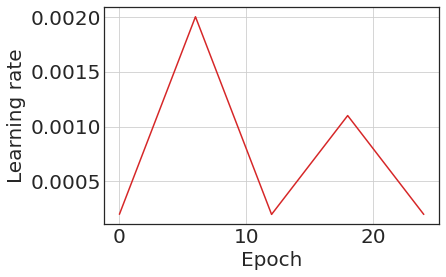

In [21]:
batches = np.linspace(0,len(metrics['lrs']),len(metrics['lrs'])+1)
epoch_list = batches/iterations_per_epoch

plt.plot(epoch_list[1:],metrics['lrs'], 'C3-')
plt.grid()
plt.ylabel("Learning rate")
plt.xlabel("Epoch")

Text(0.5, 45.5, 'Epochs')

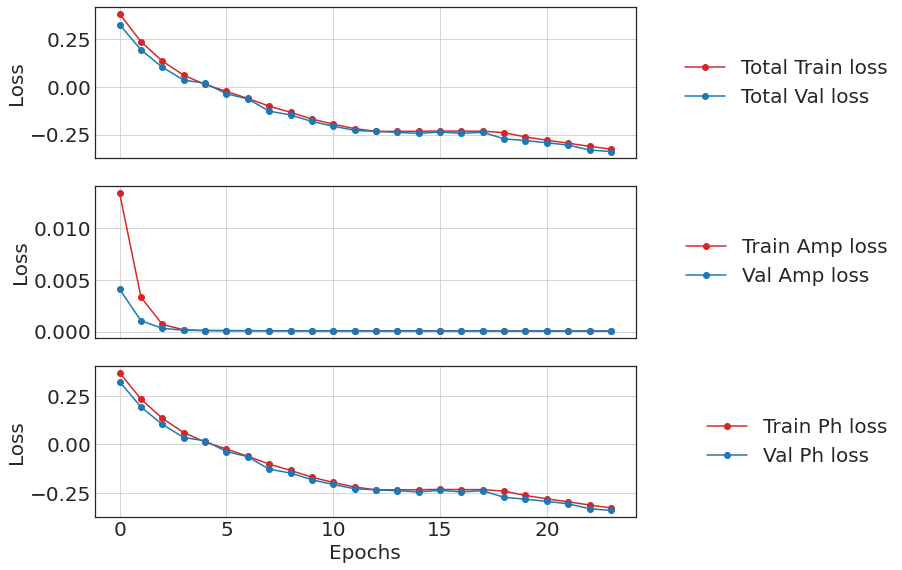

In [22]:
losses_arr = np.array(metrics['losses'])
val_losses_arr = np.array(metrics['val_losses'])
losses_arr.shape
fig, ax = plt.subplots(3,sharex=True, figsize=(15, 8))
ax[0].plot(losses_arr[:,0], 'C3o-', label = "Total Train loss")
ax[0].plot(val_losses_arr[:,0], 'C0o-', label = "Total Val loss")
ax[0].set(ylabel='Loss')
ax[0].grid()
ax[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[1].plot(losses_arr[:,1], 'C3o-', label = "Train Amp loss")
ax[1].plot(val_losses_arr[:,1], 'C0o-', label = "Val Amp loss")
ax[1].set(ylabel='Loss')
ax[1].grid()
ax[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
ax[2].plot(losses_arr[:,2], 'C3o-', label = "Train Ph loss")
ax[2].plot(val_losses_arr[:,2], 'C0o-', label = "Val Ph loss")
ax[2].set(ylabel='Loss')
ax[2].grid()
ax[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

plt.tight_layout()
plt.xlabel("Epochs")

In [23]:
#model.eval() #imp when have dropout etc
model.train() #Dropout must be retained for model UQ

amps_preds_UQ = []
ph_preds_UQ = []
def predict(model, testloader):
    amps_preds = []
    phs_preds = []
    for i, ft_images in enumerate(testloader):
        ft_images = ft_images[0].to(device)
        amp_eval, ph_eval = model(ft_images)
        for j in range(ft_images.shape[0]):
            amps_preds.append(amp_eval[j].detach().to("cpu").numpy())
            phs_preds.append(ph_eval[j].detach().to("cpu").numpy())

    amps_preds = np.array(amps_preds).squeeze()
    phs_preds = np.array(phs_preds).squeeze()
    return amps_preds, phs_preds

for i in tqdm(range(params.NPREDS)):
    a, b = predict(model, testloader)
    amps_preds_UQ.append(a)
    ph_preds_UQ.append(b)

amps_preds_UQ = np.array(amps_preds_UQ)
ph_preds_UQ = np.array(ph_preds_UQ)
print(amps_preds_UQ.shape, amps_preds_UQ.dtype)
print(ph_preds_UQ.shape, ph_preds_UQ.dtype)

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

(10, 3600, 2, 64, 64) float16
(10, 3600, 2, 64, 64) float16


In [24]:
#Get the epistemic means
amp_means = np.mean(amps_preds_UQ, axis =0) #Mean over N passes over dropout laced PtychoNN
ph_means = np.mean(ph_preds_UQ, axis =0) #Mean over N passes over dropout laced PtychoNN
print(amp_means.shape, ph_means.shape)

#Get the aleatoric stds
epsitemic_amp_std = np.std(amps_preds_UQ, axis=0)[:,0]
epsitemic_ph_std = np.std(ph_preds_UQ, axis=0)[:,0]
print(epsitemic_amp_std.shape,epsitemic_ph_std.shape)

#Get the aleatoric means
amps_eval = amp_means[:,0,:,:]
phs_eval = ph_means[:,0,:,:]
print(amps_eval.shape, phs_eval.shape)

#Get the aleatoric stds
amps_aleatoric_std = np.exp(0.5*amp_means[:,1,:,:])
phs_aleatoric_std = np.exp(0.5*ph_means[:,1,:,:]) #Output is log variance, so take exp here
print(amps_aleatoric_std.shape, phs_aleatoric_std.shape)



(3600, 2, 64, 64) (3600, 2, 64, 64)
(3600, 64, 64) (3600, 64, 64)
(3600, 64, 64) (3600, 64, 64)
(3600, 64, 64) (3600, 64, 64)


## Plot the single shot predictions

<Figure size 432x288 with 0 Axes>

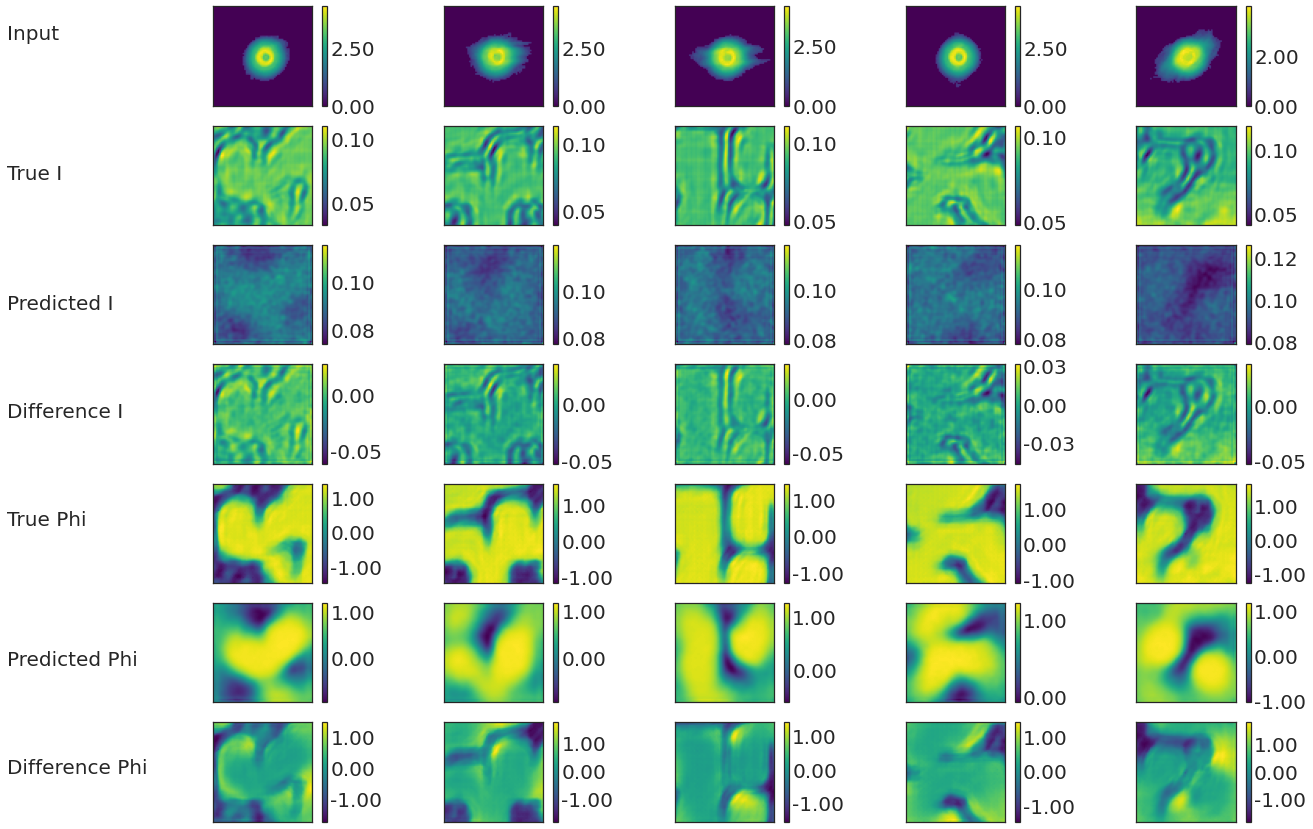

In [25]:
h,w = params.H,params.W
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT

    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)
    
    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(amps_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(phs_eval[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w) - amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w) - phs_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

## Plot the single shot uncertainties

<Figure size 432x288 with 0 Axes>

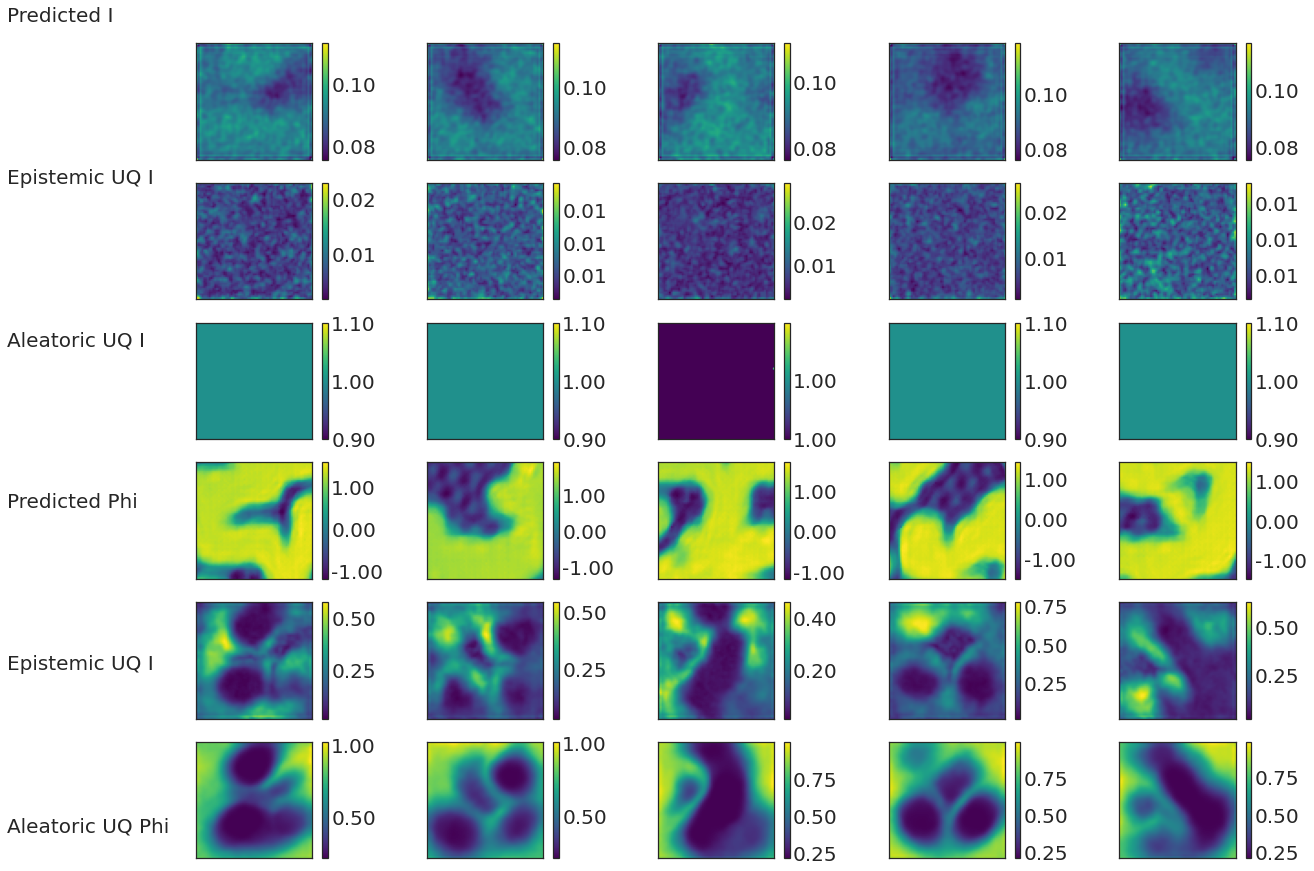

In [26]:
h,w = params.H,params.W
ntest=amps_eval.shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(6,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.9, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.75, "Epistemic UQ I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Aleatoric UQ I", fontsize=20)
plt.gcf().text(0.02, 0.45, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.3, "Epistemic UQ I", fontsize=20)
plt.gcf().text(0.02, 0.15, "Aleatoric UQ Phi", fontsize=20)


for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display predicted intens
    im=ax[0,i].imshow(amps_eval[j].reshape(h, w))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display Epistemic UQ intens
    im=ax[1,i].imshow(epsitemic_amp_std[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display Aleatoric UQ intens
    im=ax[2,i].imshow(amps_aleatoric_std[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[3,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)

    # display epistemic UQ phase
    im=ax[4,i].imshow(epsitemic_ph_std[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display aleatoric UQ phase
    im=ax[5,i].imshow(phs_aleatoric_std[j].reshape(h, w).astype('float32'))
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    
plt.show()

In [27]:
def stitcher(arr):
    tst_side = 60
    point_size = 3
    overlap = 4*point_size

    composite = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
    ctr = np.zeros_like(composite)
    data_reshaped = arr.reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                        32-int(overlap/2):32+int(overlap/2)]

    for i in range(tst_side):
        for j in range(tst_side):
            composite[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
            ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1

    stitched = composite[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)]

    stitched_down = resize(stitched, (tst_side,tst_side), preserve_range=True, anti_aliasing=True)
    return stitched_down



In [28]:
stitched_amp_down = stitcher(amps_eval)
stitched_phase_down = stitcher(phs_eval)
stitched_phase_ale = stitcher(phs_aleatoric_std)
stitched_amp_ale = stitcher(amps_aleatoric_std)
stitched_amp_epi = stitcher(epsitemic_amp_std)
stitched_phase_epi = stitcher(epsitemic_ph_std)

true_amp = Y_I_test.reshape(params.NLTEST,params.NLTEST,64,64)
true_ph = Y_phi_test.reshape(params.NLTEST,params.NLTEST,64,64)


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


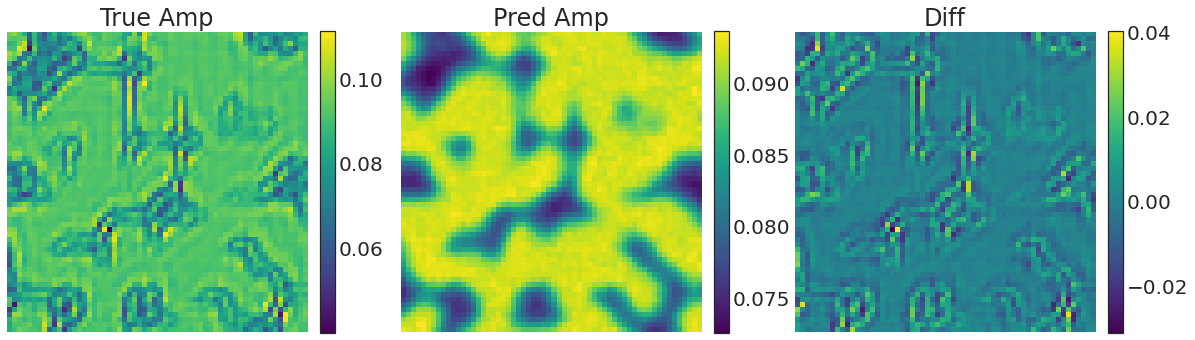

In [29]:
plot3([true_amp[:,:,32,32],stitched_amp_down,stitched_amp_down-true_amp[:,:,32,32]],["True Amp", "Pred Amp", "Diff"])

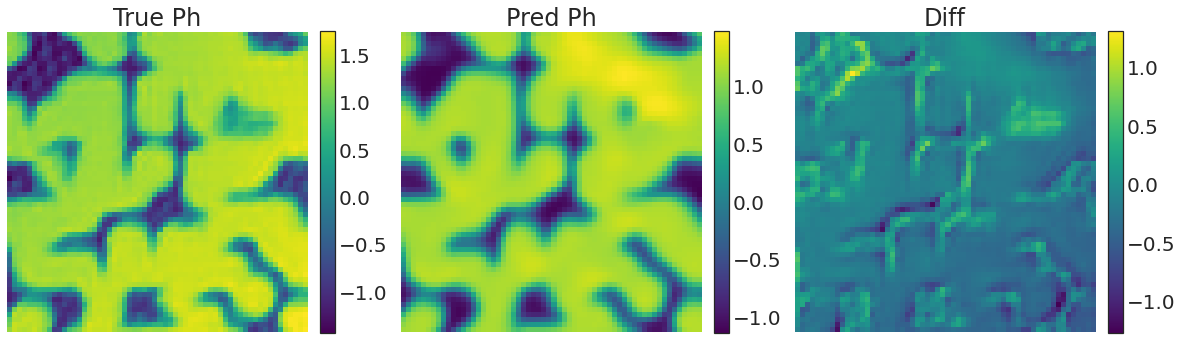

In [30]:
plot3([true_ph[:,:,32,32],stitched_phase_down,stitched_phase_down-true_ph[:,:,32,32]],["True Ph", "Pred Ph", "Diff"])

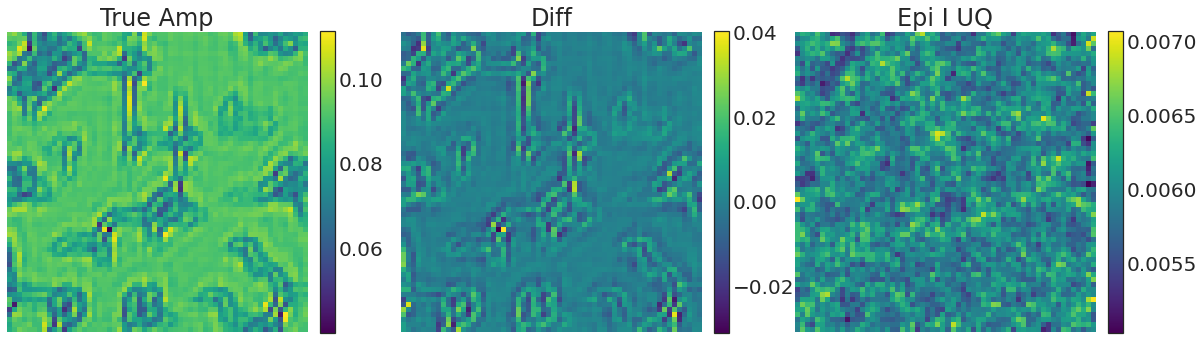

In [31]:
plot3([true_amp[:,:,32,32],stitched_amp_down-true_amp[:,:,32,32],stitched_amp_epi],["True Amp", "Diff", "Epi I UQ"])

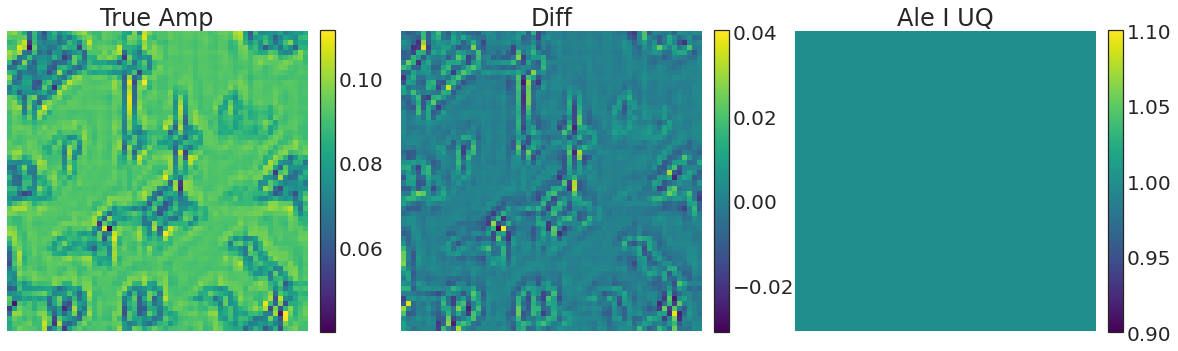

In [32]:
plot3([true_amp[:,:,32,32],stitched_amp_down-true_amp[:,:,32,32],stitched_amp_ale],["True Amp", "Diff", "Ale I UQ"])

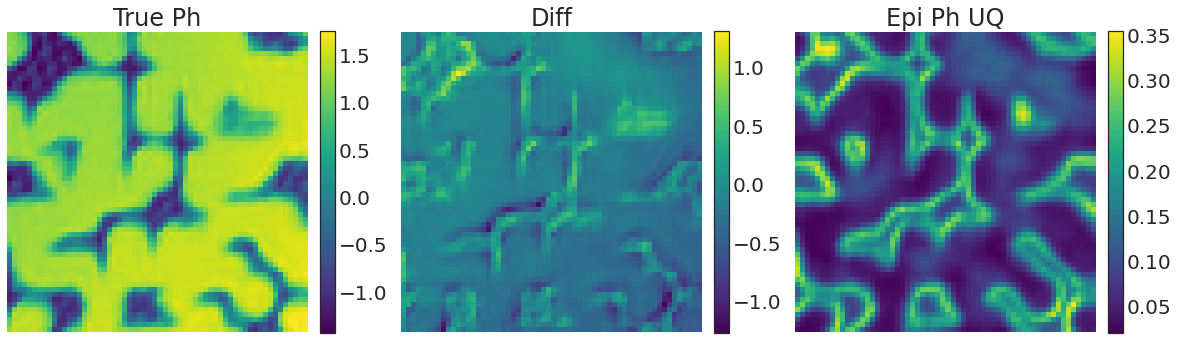

In [33]:
plot3([true_ph[:,:,32,32],stitched_phase_down-true_ph[:,:,32,32],stitched_phase_epi],["True Ph", "Diff", "Epi Ph UQ"])

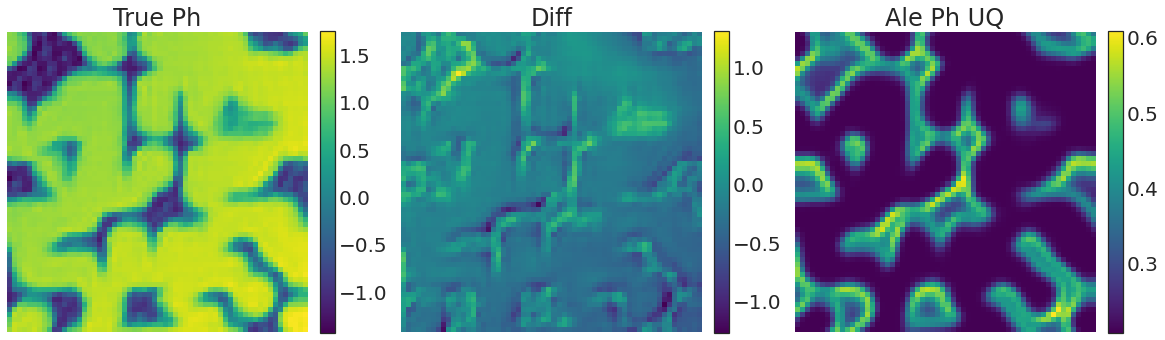

In [34]:
plot3([true_ph[:,:,32,32],stitched_phase_down-true_ph[:,:,32,32],stitched_phase_ale],["True Ph", "Diff", "Ale Ph UQ"])

In [35]:
from sklearn.metrics import mean_squared_error as mse
from skimage.registration import phase_cross_correlation
print ("MSE in amplitude: ", mse(stitched_amp_down, true_amp[:,:,32,32]))
print ("MSE in phase: ", mse(stitched_phase_down, true_ph[:,:,32,32]))

MSE in amplitude:  5.1685772633114745e-05
MSE in phase:  0.09434759924031678


In [36]:
true_img = true_amp * np.exp(1j * true_ph)
stitched_img = stitched_amp_down * np.exp(1j * stitched_phase_down)

In [37]:
_roll, _err, _phase = phase_cross_correlation(true_img[:,:,32, 32], stitched_img)
phase_cross_correlation(true_img[:,:,32,32], stitched_img * np.exp(1j * _phase))

(array([0., 0.]), 0.9998909467382092, 5.0103125274866295e-17)